In [2]:
# Torch 계열
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [2]:
######## Test용 ############
# scaler = load(open('MinMax_scaler_Head_230921.pkl', 'rb'))    #Scaler 불러오기

In [19]:
# Load the dataset _Mix
# X = np.load('EBR32094107_BOT_Head100_x.npy', allow_pickle=True)  
## X = X[:, :15] 으로 학습 시, Epoch [31/100000], Train Loss: 0.00883, Train Acc: 0.911, Valid Loss: 0.02390, Valid Acc: 0.902
# y = np.load('All_Head_Simple_NoMix_y.npy')
# category_var = np.load('EBR32094107_BOT_Head100_y.npy', allow_pickle=True)

# X = np.load('All_Head_Simple_NoMix_x.npy')  # 여기 데이터셋으로 검증하면 정확도 0.89 임
# category_var = np.load('All_Head_Simple_NoMix_y.npy')

# X = np.load('All_Head_Simple_x.npy')
# category_var = np.load('All_Head_Simple_y.npy')

# X = np.load('D:/py/DGS/EBR32094107_BOT_Head66_x.npy', allow_pickle=True)
# category_var = np.load('D:/py/DGS/EBR32094107_BOT_Head66_y.npy', allow_pickle=True)

# X = np.load('D:/py/DGS/EBR32094107_BOT_Head_NoMix_x.npy', allow_pickle=True)
# category_var = np.load('D:/py/DGS/EBR32094107_BOT_Head_NoMix_y.npy', allow_pickle=True)

######################################################
#### 학습 / 검증용 #########
# X = np.load('Head_230921_2_x.npy', allow_pickle=True)
# # X = X[ : , :14]  # 테스트용 동일 모델에서는 옵션값만 있으면 학습이되는지 확인하기 위함 : 결과) 동일 모델로 구성된 데이터셋에서 부품정보없이, 옵션정보만 입력해도 예측율 동일 수준 임

# category_var = np.load('Head_230921_2_y.npy', allow_pickle=True)
# # print(category_var[:10])


# X = X.astype(np.int)
# category_var = category_var.astype(np.int)

# num_category = len(np.unique(category_var))+1 ## 유니크 범주 개수
# identity_mat = np.eye(num_category) ## 단위 행렬
# y = identity_mat[category_var] ## 범주에 대응하는 행 추출

# print(X.shape , y.shape)
# X_train, X_test, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# le = LabelEncoder()
# # scaler = StandardScaler()
# scaler = MinMaxScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_test)
##########################################################################


##########################################################################
######## Test용 ############
# X = np.load('Head_230921_2_test_x.npy', allow_pickle=True)
# category_var = np.load('Head_230921_2_test_y.npy', allow_pickle=True)

# X = X.astype(np.int)
# category_var = category_var.astype(np.int)

# num_category = len(np.unique(category_var))+1 ## 유니크 범주 개수
# identity_mat = np.eye(num_category) ## 단위 행렬
# y = identity_mat[category_var] ## 범주에 대응하는 행 추출

# print(X.shape , y.shape)
# X_train, X_test, y_train, y_valid = train_test_split(X, y, test_size=0.99, random_state=42)

# le = LabelEncoder()
# # scaler = StandardScaler()
# # scaler = MinMaxScaler()
# scaler = load(open('MinMax_scaler_Head_230921.pkl', 'rb'))    #Scaler 불러오기

### X_train_scaled = scaler.fit_transform(X_train)    # Test 시, 사용하면 안됨
# X_valid_scaled = scaler.transform(X_test)
# print(X_valid_scaled.shape)
###########################################################################


##########################################################################
######## NoTrain 용 ############
X = np.load('Head_230921_2_NoTrain_x.npy', allow_pickle=True)
category_var = np.load('Head_230921_2_NoTrain_y.npy', allow_pickle=True)

X = X.astype(np.int)
category_var = category_var.astype(np.int)

num_category = len(np.unique(category_var))+1 ## 유니크 범주 개수
identity_mat = np.eye(num_category) ## 단위 행렬
y = identity_mat[category_var] ## 범주에 대응하는 행 추출

print(X.shape , y.shape)
X_test = X
y_valid = y

le = LabelEncoder()
# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = load(open('MinMax_scaler_Head_230921.pkl', 'rb'))    #Scaler 불러오기

X_valid_scaled = scaler.transform(X_test)
print(X_valid_scaled.shape)
###########################################################################

inputsize = X.shape[1]
num_classes = y.shape[2]
outsize = len(y[0])

print(inputsize , num_classes , outsize)


(1, 32055) (1, 32041, 10)
(1, 32055)
32055 10 32041


In [24]:
# dump(scaler, open('MinMax_scaler_Head_230921.pkl', 'wb'))   #Scaler 저장
# scaler = load(open('MinMax_scaler_Head_230921.pkl', 'rb'))    #Scaler 불러오기

# 스케일러 사용
# X_test_scaled = scaler.transform(X_test)  #참조용

In [4]:
# 데이터셋 클래스 정의
class AssemblyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [5]:
# 모델 클래스 정의
class AssemblyClassifier(nn.Module):
    def __init__(self, hiddenlayer , input_size, nozzle_loc, num_nozzle):
        super(AssemblyClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hiddenlayer),
            nn.ReLU(),
            nn.Linear(hiddenlayer, hiddenlayer),
            nn.ReLU(),
            nn.Linear(hiddenlayer, hiddenlayer),
            nn.ReLU(),
            nn.Linear(hiddenlayer,nozzle_loc*num_nozzle)
        )
        self.nozzle_loc = nozzle_loc
        self.num_nozzle = num_nozzle

    def forward(self, x):
        output = self.fc(x)
        x = output.view(-1, self.nozzle_loc,self.num_nozzle)
        return x

class RNNmodel(nn.Module):
    def __init__(self, hiddenlayer , input_size, nozzle_loc, num_nozzle):
        super(RNNmodel, self).__init__()
        self.fc = nn.Sequential(
            nn.RNN(input_size, hiddenlayer),
            # nn.ReLU(),
            nn.RNN(hiddenlayer, hiddenlayer),
            # nn.ReLU(),
            nn.RNN(hiddenlayer, hiddenlayer),
            # nn.ReLU(),
            nn.Linear(hiddenlayer,nozzle_loc*num_nozzle)
        )
        self.nozzle_loc = nozzle_loc
        self.num_nozzle = num_nozzle

    def forward(self, x):
        output = self.fc(x)
        print(output)
        x = output.view(-1, self.nozzle_loc,self.num_nozzle)
        return x

In [6]:
# 하이퍼파라미터 설정
learning_rate = 0.001
weight_decay = 0.0000001
num_epochs = 100000
batch_size = 32
hiddenlayer = 1000

device = torch.device("cuda:0")
model = AssemblyClassifier(hiddenlayer = hiddenlayer,input_size=inputsize, nozzle_loc=outsize, num_nozzle=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay = weight_decay)

In [20]:
# train_dataset = AssemblyDataset(X_train_scaled, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = AssemblyDataset(X_valid_scaled, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# 학습 진행
t = time.time()
best_result = 0

trn_loss_list = []
val_loss_list = []
trn_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    # train 데이터셋으로 학습
    model.train()
    cnt = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        X_trn,Y_trn = inputs.to(device),labels.to(device)
        outputs = model(X_trn)
        loss = criterion(outputs.view(-1,Y_trn.shape[2]), Y_trn.argmax(dim=2).view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss        
        pred = outputs.argmax(dim=2)
        Y_trn = Y_trn.argmax(dim=2)
        correct = torch.eq(pred,Y_trn).sum(dim=1)
        train_acc += torch.sum(correct // Y_trn.shape[1])       
        cnt = i
        
    # validation 데이터셋으로 검증
    with torch.no_grad():
        model.eval()
        rescheck = 0
        for i, (inputs, labels) in enumerate(valid_loader):
            X_val,Y_val = inputs.to(device),labels.to(device)
            outputs = model(X_val)
            loss = criterion(outputs.view(-1,Y_val.shape[2]), Y_val.argmax(dim=2).view(-1))
            valid_loss += loss
            pred = outputs.argmax(dim=2)
            Y_val = Y_val.argmax(dim=2)
            correct = torch.eq(pred,Y_val).sum(dim=1)
            valid_acc += torch.sum(correct // Y_val.shape[1])
            rescheck = i

    # epoch별 평균 손실과 정확도 계산
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader)
    valid_acc = valid_acc / len(valid_loader.dataset) 
    
    trn_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    trn_acc_list.append(train_acc)
    val_acc_list.append(valid_acc)
    
    if valid_acc > best_result:
        best_result = valid_acc
        torch.save(model.state_dict(), "dnn_Head_All_230921_2.pt")

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.3f}, Valid Loss: {valid_loss:.5f}, Valid Acc: {valid_acc:.3f}')
    
elapsed_time = time.time() - t

print(f'elapsed_time: {elapsed_time}')

Epoch [1/100000], Train Loss: 0.31192, Train Acc: 0.000, Valid Loss: 0.03791, Valid Acc: 0.000



KeyboardInterrupt



In [ ]:
with torch.no_grad():
    model.eval()
    rescheck = 0
    for i, (inputs, labels) in enumerate(valid_loader):
        X_val,Y_val = inputs.to(device),labels.to(device)
        outputs = model(X_val)
        loss = criterion(outputs.view(-1,Y_val.shape[2]), Y_val.argmax(dim=2).view(-1))
        # loss = criterion(outputs.view(-1, num_classes), Y_val.view(-1))

        valid_loss += loss

        pred = outputs.argmax(dim=2)
        # label = Y_val.argmax(dim=2)
        pred = outputs.argmax(dim=2)
        Y_val = Y_val.argmax(dim=2)
        correct = torch.eq(pred,Y_val).sum(dim=1)
        print(correct , pred ,Y_val )
        valid_acc += torch.sum(correct // Y_val.shape[1])

In [8]:

#검증 및 테스용 코드
model_load = AssemblyClassifier(hiddenlayer = hiddenlayer,input_size=inputsize, nozzle_loc=outsize, num_nozzle=num_classes).to(device)
model_load.load_state_dict(torch.load("dnn_Head_All_230921_2.pt"))

<All keys matched successfully>

In [21]:
with torch.no_grad():
    model_load.eval()
    valid_acc = 0
    total_cnt = 0
    total_correct = 0
    correct_list = []
    pred_list = []
    for i, (inputs, labels) in enumerate(valid_loader):
        X_val,Y_val = inputs.to(device),labels.to(device)
        outputs = model_load(X_val)
        # loss = criterion(outputs.view(-1,Y_val.shape[2]), Y_val.argmax(dim=2).view(-1))
        # loss = criterion(outputs.view(-1, num_classes), Y_val.view(-1))

        # valid_loss += loss

        pred = outputs.argmax(dim=2)
        # label = Y_val.argmax(dim=2)
        pred = outputs.argmax(dim=2)
        Y_val = Y_val.argmax(dim=2)
        correct = torch.eq(pred,Y_val).sum(dim=1)
        # print(correct , pred ,Y_val )
        valid_acc += torch.sum(correct // Y_val.shape[1])

        #변경 방식
        pred_np = pred.cpu().numpy()
        pred_np = pred_np.reshape(-1)
        Y_val_np = Y_val.cpu().numpy()
        Y_val_np = Y_val_np.reshape(-1)
        # print(pred_np.shape , Y_val_np.shape , len(pred_np))
        for i in range(len(Y_val_np)):
            if Y_val_np[i] != 0:
                total_cnt+=1
                correct_list.append(Y_val_np[i])
                pred_list.append(pred_np[i])
                if Y_val_np[i] == pred_np[i]:
                    total_correct+=1

    # print(correct , Y_val.shape , valid_acc , len(valid_loader.dataset) , rescheck+1)
    valid_acc = valid_acc / len(valid_loader.dataset) 
    print(valid_acc)

    my_val_acc = total_correct / total_cnt
    print('my_val_acc : ' , my_val_acc)

tensor(0., device='cuda:0')
my_val_acc :  0.32137030995106036


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score , classification_report

# Evaluate the accuracy of the model

print(confusion_matrix(correct_list , pred_list))
print('학습' , classification_report(correct_list , pred_list))

[[ 0  0  0  0  0  0  0  0  0]
 [ 2 39 41 43 11  0  0  0  0]
 [ 5 84 17  8 35  0  0  0  0]
 [ 4  3 50 33 23  0  0  0  0]
 [16  8  2 18 41 31  0  0  0]
 [ 4  0  2 12  2 35  0  0  0]
 [ 2  0  0  0  0  0 23  0  0]
 [ 3  0  0  0  0  0  6  4  0]
 [ 0  0  0  0  0  0  1  0  5]]
학습               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.29      0.29      0.29       136
           2       0.15      0.11      0.13       149
           3       0.29      0.29      0.29       113
           4       0.37      0.35      0.36       116
           5       0.53      0.64      0.58        55
           6       0.77      0.92      0.84        25
           7       1.00      0.31      0.47        13
           8       1.00      0.83      0.91         6

    accuracy                           0.32       613
   macro avg       0.49      0.42      0.43       613
weighted avg       0.33      0.32      0.32       613



In [35]:
for i in range(0,9):
    print(pred_list.count(i))
    print(correct_list.count(i))

print(len(pred_list) , len(correct_list))

36
0
134
136
112
149
114
113
112
116
66
55
30
25
4
13
5
6
613 613


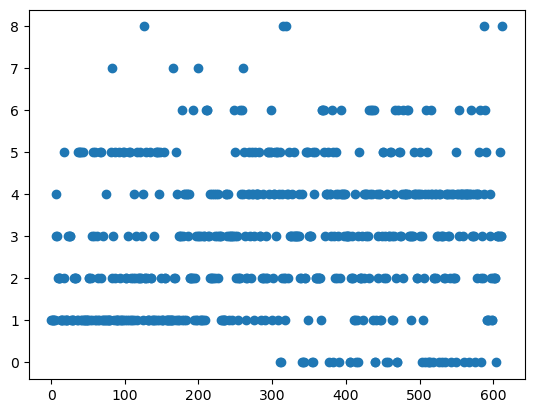

In [34]:
import matplotlib
list_y = [ i for i in range(len(pred_list))]
plt.scatter(list_y , pred_list)
plt.show()